In [ ]:
!pip install -r https://raw.githubusercontent.com/datamllab/automl-in-action-notebooks/master/requirements.txt

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AutoencoderModel(Model):
  def __init__(self, latent_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder_layer = layers.Dense(latent_dim, activation='relu')
    self.decoder_layer = layers.Dense(784, activation='sigmoid')

  def encode(self, encoder_input):
    encoder_output = layers.Flatten()(encoder_input)
    encoder_output = self.encoder_layer(encoder_output)
    return encoder_output

  def decode(self, decoder_input):
    decoder_output = decoder_input
    decoder_output = self.decoder_layer(decoder_output)
    decoder_output = layers.Reshape((28, 28))(decoder_output)
    return decoder_output

  def call(self, x):
    return self.decode(self.encode(x))

In [5]:
import numpy as np

tf.random.set_seed(5)
np.random.seed(5)
autoencoder = AutoencoderModel(64)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

autoencoder.evaluate(x_test, x_test)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0241 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.00

0.008974517695605755

In [6]:
autoencoder.encode(x_test[:1])

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[3.9311156 , 1.0182607 , 6.559645  , 2.8951705 , 1.5840764 ,
        2.3559616 , 2.0955117 , 4.4853435 , 1.3493909 , 3.6009746 ,
        3.5480032 , 1.0803825 , 3.5926106 , 2.3408904 , 0.        ,
        1.3521018 , 1.542365  , 3.713235  , 2.2019303 , 1.3938731 ,
        0.9601334 , 2.390303  , 1.4392258 , 2.155833  , 4.196291  ,
        3.810984  , 3.2413588 , 1.1022315 , 2.7478027 , 0.        ,
        6.340748  , 2.589056  , 1.9056277 , 0.61499566, 1.7429416 ,
        0.59232974, 2.5122232 , 1.470579  , 1.5797862 , 2.317978  ,
        0.19336802, 1.6040546 , 1.8269937 , 2.1929226 , 3.598294  ,
        2.1040347 , 3.4453382 , 3.4056299 , 3.6934063 , 2.5358934 ,
        2.8133383 , 4.4626193 , 2.0303516 , 3.790923  , 2.4032137 ,
        2.2115908 , 2.5821424 , 1.4490024 , 2.3869786 , 0.        ,
        3.2467706 , 1.1970189 , 0.51507854, 0.7152039 ]], dtype=float32)>

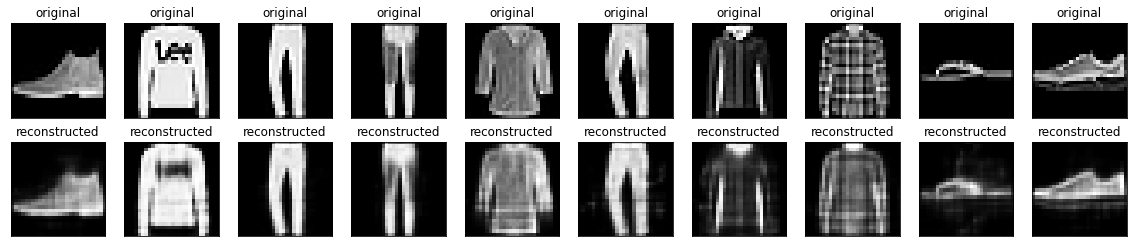

In [7]:
import matplotlib.pyplot as plt

def show_images(model, images):
  encoded_imgs = model.encode(images).numpy()
  decoded_imgs = model.decode(encoded_imgs).numpy()

  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

show_images(autoencoder, x_test)

In [8]:
import keras_tuner
from tensorflow import keras
from keras_tuner import RandomSearch

class AutoencoderBlock(keras.Model):
  def __init__(self, latent_dim, hp):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder_layers = []
    for i in range(hp.Int("encoder_layers",
                          min_value=0,
                          max_value=2,
                          step=1,
                          default=0)):
      self.encoder_layers.append(
          layers.Dense(units=hp.Choice("encoder_layers_{i}".format(i=i),
                                       [64, 128, 256]),
                       activation='relu'))
    self.encoder_layers.append(layers.Dense(latent_dim, activation='relu'))
    self.decoder_layers = []
    for i in range(hp.Int("decoder_layers",
                          min_value=0,
                          max_value=2,
                          step=1,
                          default=0)):
      self.decoder_layers.append(
          layers.Dense(units=hp.Choice("decoder_layers_{i}".format(i=i),
                                       [64, 128, 256]),
                       activation='relu'))
    self.decoder_layers.append(layers.Dense(784, activation='sigmoid'))

  def encode(self, encoder_input):
    encoder_output = layers.Flatten()(encoder_input)
    for layer in self.encoder_layers:
      encoder_output = layer(encoder_output)
    return encoder_output

  def decode(self, decoder_input):
    decoder_output = decoder_input
    for layer in self.decoder_layers:
      decoder_output = layer(decoder_output)
    decoder_output = layers.Reshape((28, 28))(decoder_output)
    return decoder_output

  def call(self, x):
    return self.decode(self.encode(x))

In [9]:
def build_model(hp):
  latent_dim = 20
  autoencoder = AutoencoderBlock(latent_dim, hp)
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True,
    directory='my_dir',
    project_name='helloworld')

tuner.search(x_train, x_train,
             epochs=10,
             validation_data=(x_test, x_test))

Trial 10 Complete [00h 01m 51s]
val_loss: 0.011775245890021324

Best val_loss So Far: 0.011416561901569366
Total elapsed time: 00h 12m 44s
INFO:tensorflow:Oracle triggered exit


Results summary
Results in my_dir/helloworld
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
encoder_layers: 1
decoder_layers: 1
encoder_layers_0: 64
decoder_layers_0: 256
Score: 0.011416561901569366
313/313 [==============================] - 1s 2ms/step - loss: 0.0114


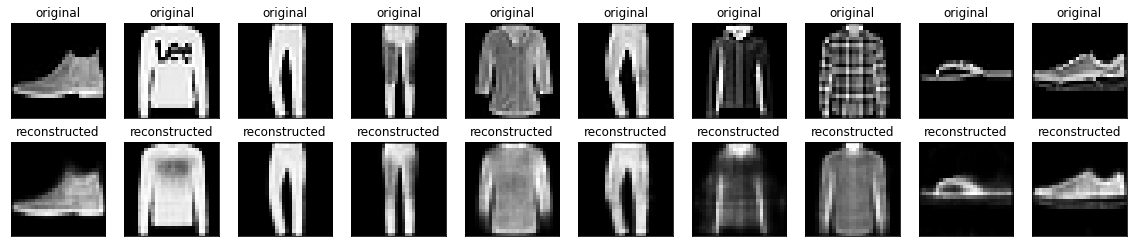

In [10]:
autoencoder = tuner.get_best_models(num_models=1)[0]
tuner.results_summary(1)
autoencoder.evaluate(x_test, x_test)

show_images(autoencoder, x_test)